## Project of Machine Learning

Purpose : Find the best roommate with a data of Wellbeing and lifestyle

for this project, we use the dataset from Kaggle : https://www.kaggle.com/c/wellbeing-and-lifestyle/data

we must define whether we use classification or regression


Imports:

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

Loading of the CSV data set

In [19]:
file_path = os.path.join(os.getcwd(), "Wellbeing_and_lifestyle_data.csv")

try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("File not found")

print("Column names:\n")
print(df.columns.tolist())

print("\nNumerical columns:\n")
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(num_cols.tolist())

print("\nCategorical columns:\n")
cat_cols = df.select_dtypes(include=['object', 'category']).columns
print(cat_cols.tolist())

file_path = os.path.join(os.getcwd(), "Wellbeing_and_lifestyle_data.csv")
try:
    for col in cat_cols:
        print(f"\nColumn: {col}")
        print(df[col].unique()[:15], "...")
        df = pd.read_csv(file_path)

except FileNotFoundError:
    print("File not found")
    

print(df.describe())
print(df.head())



       FRUITS_VEGGIES  PLACES_VISITED   CORE_CIRCLE  SUPPORTING_OTHERS  \
count    15972.000000    15972.000000  15972.000000       15972.000000   
mean         2.922677        5.232970      5.508077           5.616454   
std          1.442694        3.311912      2.840334           3.242021   
min          0.000000        0.000000      0.000000           0.000000   
25%          2.000000        2.000000      3.000000           3.000000   
50%          3.000000        5.000000      5.000000           5.000000   
75%          4.000000        8.000000      8.000000          10.000000   
max          5.000000       10.000000     10.000000          10.000000   

       SOCIAL_NETWORK   ACHIEVEMENT      DONATION     BMI_RANGE  \
count    15972.000000  15972.000000  15972.000000  15972.000000   
mean         6.474267      4.000751      2.715314      1.410656   
std          3.086672      2.755837      1.851586      0.491968   
min          0.000000      0.000000      0.000000      1.000000  

# Data exploration

## Types of Data
dtypes: float64(1), int64(19), object(4)

Object : Age, Gender, Timestamp, DAILY_STRESS

Float64 : Work_Life_Balance_Score

We must transform the Object into numerical values

For DAILY_STRESS => we had one data (1/1/0) who isn't INT on around 15K samples), result: we delete the row




In [20]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15972 entries, 0 to 15971
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   FRUITS_VEGGIES     15972 non-null  int64 
 1   DAILY_STRESS       15972 non-null  object
 2   PLACES_VISITED     15972 non-null  int64 
 3   CORE_CIRCLE        15972 non-null  int64 
 4   SUPPORTING_OTHERS  15972 non-null  int64 
 5   SOCIAL_NETWORK     15972 non-null  int64 
 6   ACHIEVEMENT        15972 non-null  int64 
 7   DONATION           15972 non-null  int64 
 8   BMI_RANGE          15972 non-null  int64 
 9   TODO_COMPLETED     15972 non-null  int64 
 10  FLOW               15972 non-null  int64 
 11  DAILY_STEPS        15972 non-null  int64 
 12  LIVE_VISION        15972 non-null  int64 
 13  SLEEP_HOURS        15972 non-null  int64 
 14  LOST_VACATION      15972 non-null  int64 
 15  DAILY_SHOUTING     15972 non-null  int64 
 16  SUFFICIENT_INCOME  15972 non-null  int64

In [21]:
# Ensure DAILY_STRESS is numeric
df['DAILY_STRESS'] = pd.to_numeric(df['DAILY_STRESS'], errors='coerce')
before_rows = df.shape[0]
df = df.dropna(subset=['DAILY_STRESS'])
after_rows = df.shape[0]
print(f"Removed {before_rows - after_rows} row(s) with invalid DAILY_STRESS values.")



#GENDER
# onyl 2 values (Female and Male), so we translate this into 0 and 1

df["GENDER"] = df["GENDER"].map({"Female": 0, "Male": 1})

#Age
#We have 4 categories of Age :
#[less than 20, 21 to 35, 36 to 50, 51 or more]
# when it's possible, we take the half of age groupes
# for <20, we choose value : 16 and for 51 or more, we choose value : 70

# Convert AGE to numeric representation
age_mapping = {
    'Less than 20': 16,
    '21 to 35': 28,
    '36 to 50': 43,
    '51 or more': 70
}
df['AGE'] = df['AGE'].map(age_mapping)
if "Timestamp" in df.columns:
    df = df.drop(columns=["Timestamp"])
print(df.info())
print(df.shape)

Removed 1 row(s) with invalid DAILY_STRESS values.
<class 'pandas.core.frame.DataFrame'>
Index: 15971 entries, 0 to 15971
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   FRUITS_VEGGIES     15971 non-null  int64  
 1   DAILY_STRESS       15971 non-null  float64
 2   PLACES_VISITED     15971 non-null  int64  
 3   CORE_CIRCLE        15971 non-null  int64  
 4   SUPPORTING_OTHERS  15971 non-null  int64  
 5   SOCIAL_NETWORK     15971 non-null  int64  
 6   ACHIEVEMENT        15971 non-null  int64  
 7   DONATION           15971 non-null  int64  
 8   BMI_RANGE          15971 non-null  int64  
 9   TODO_COMPLETED     15971 non-null  int64  
 10  FLOW               15971 non-null  int64  
 11  DAILY_STEPS        15971 non-null  int64  
 12  LIVE_VISION        15971 non-null  int64  
 13  SLEEP_HOURS        15971 non-null  int64  
 14  LOST_VACATION      15971 non-null  int64  
 15  DAILY_SHOUTING     15971

Detailed Descriptive Statistics (including categorical)

In [22]:
print("Numerical feature statistics:")
display(df.describe())

# Check whether we have categorical columns
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print("\nCategorical columns detected:", list(cat_cols))

if len(cat_cols) > 0:
    print("\nCategorical feature statistics:")
    display(df[cat_cols].describe())
else:
    print("\nNo categorical (object/category) columns in this dataset.")



Categorical columns detected: []

No categorical (object/category) columns in this dataset.


Missing Values Map (visual)

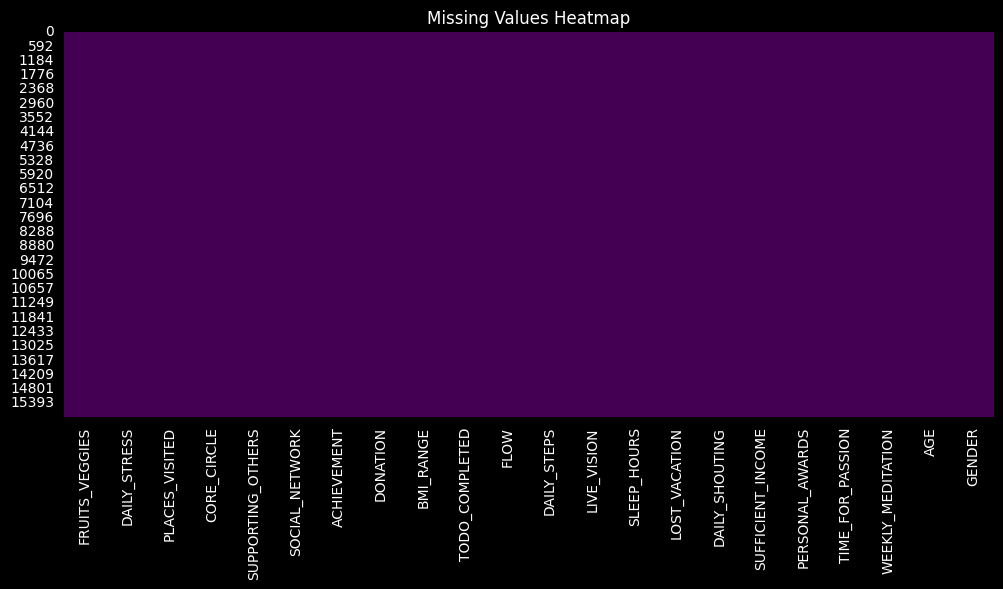

In [23]:
# MISSING VALUE VISUALIZATION

plt.figure(figsize=(12, 5))
sns.heatmap(df.isna(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


In [24]:
print(df.head())
print(df.info())


   FRUITS_VEGGIES  DAILY_STRESS  PLACES_VISITED  CORE_CIRCLE  \
0               3           2.0               2            5   
1               2           3.0               4            3   
2               2           3.0               3            4   
3               3           3.0              10            3   
4               5           1.0               3            3   

   SUPPORTING_OTHERS  SOCIAL_NETWORK  ACHIEVEMENT  DONATION  BMI_RANGE  \
0                  0               5            2         0          1   
1                  8              10            5         2          2   
2                  4              10            3         2          2   
3                 10               7            2         5          2   
4                 10               4            2         4          2   

   TODO_COMPLETED  ...  LIVE_VISION  SLEEP_HOURS  LOST_VACATION  \
0               6  ...            0            7              5   
1               5  ...            5 

Histograms for All Numerical Features

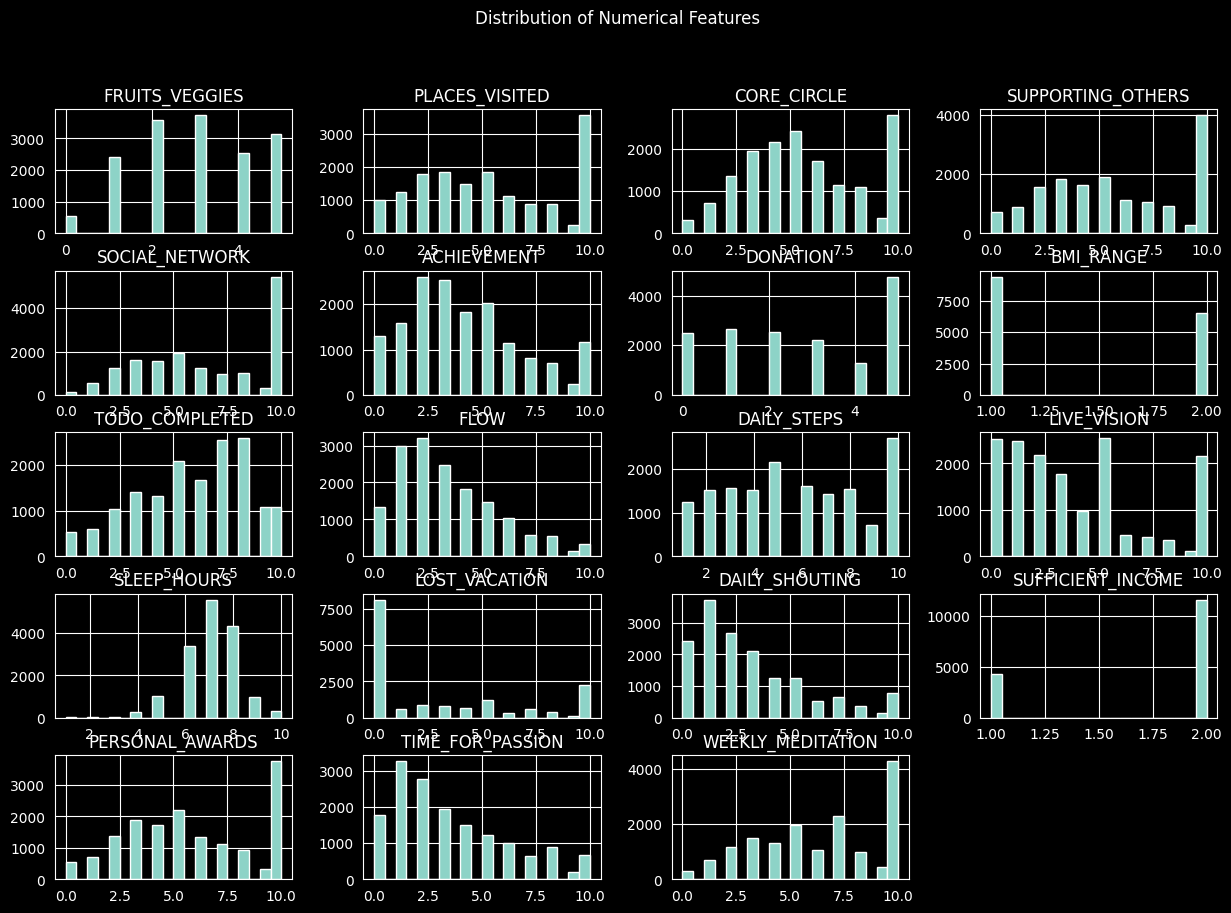

In [25]:
# HISTOGRAMS OF ALL NUMERICAL FEATURES

df[num_cols].hist(figsize=(15, 10), bins=20)
plt.suptitle("Distribution of Numerical Features")
plt.show()


Boxplots to Detect Outliers

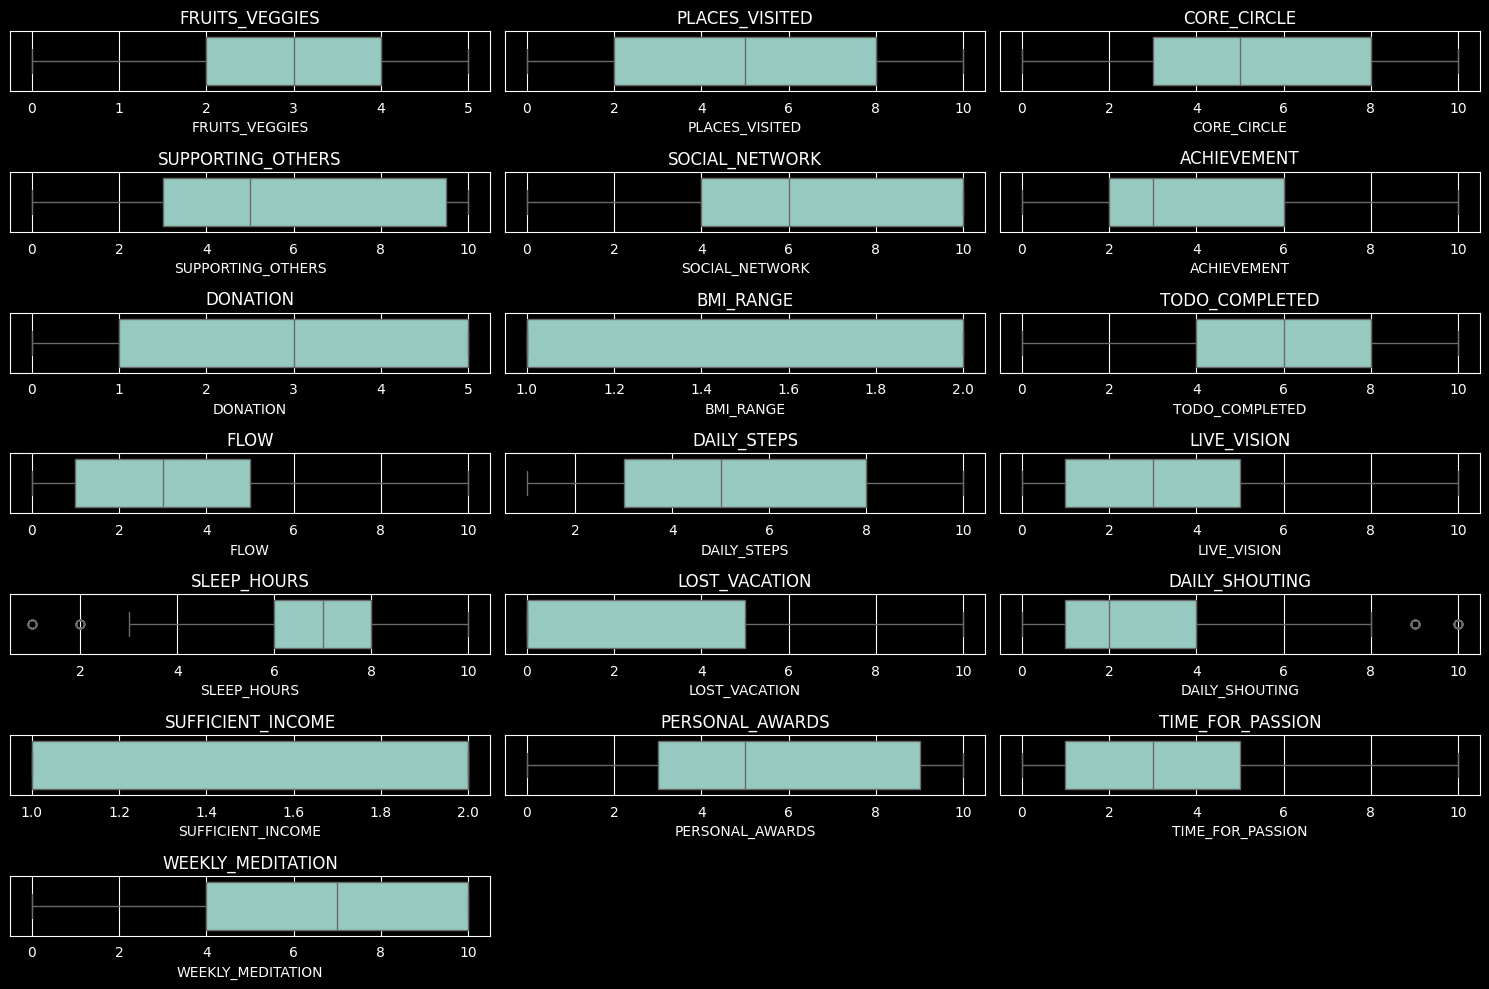

In [26]:
# BOXPLOTS FOR OUTLIER DETECTION

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(math.ceil(len(num_cols)/3), 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


Correlation Matrix Heatmap (Numerical Only)

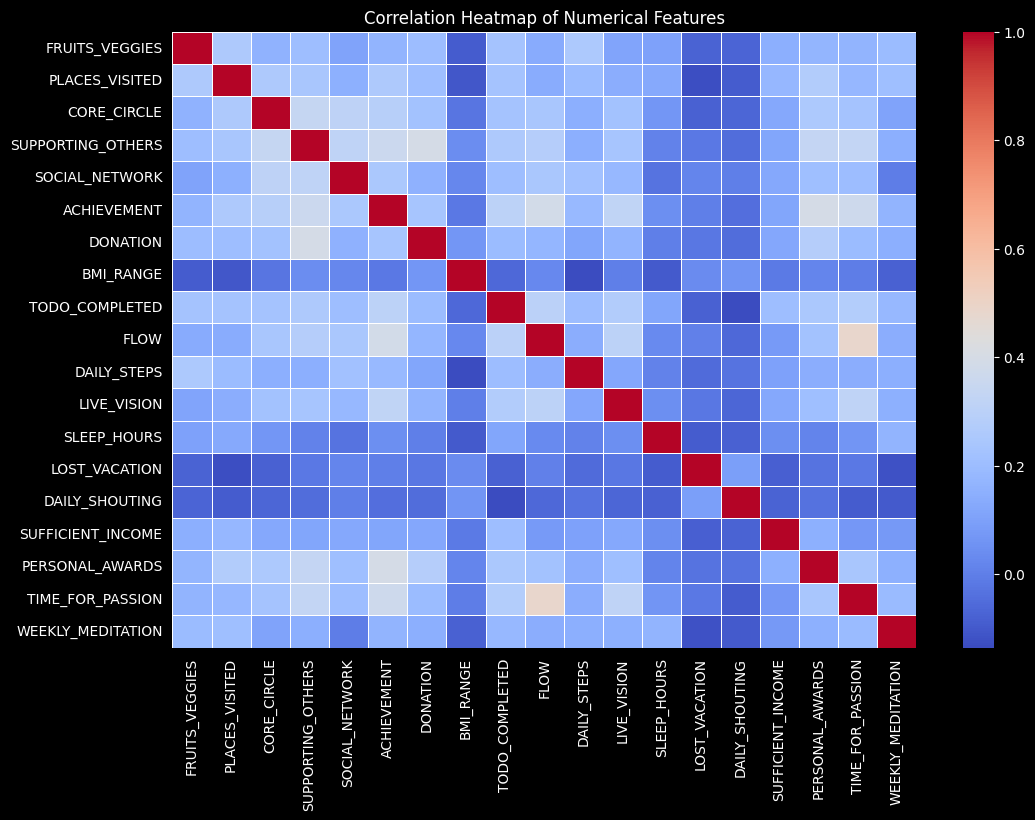

In [27]:
# CORRELATION HEATMAP

corr = df[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


Unique Values of Categorical Features

In [28]:
if len(cat_cols) == 0:
    print("No categorical columns left after encoding.")
else:
    for col in cat_cols:
        print(f"\nColumn: {col}")
        print(df[col].unique()[:15], "...")


No categorical columns left after encoding.


Basic Preprocessing Checks (without altering existing work)

In [29]:
# PREPROCESSING CHECKLIST

print("Missing values left:")
print(df.isna().sum())

print("\nDuplicate rows:", df.duplicated().sum())

print("\nData types:")
print(df.dtypes)


Missing values left:
FRUITS_VEGGIES       0
DAILY_STRESS         0
PLACES_VISITED       0
CORE_CIRCLE          0
SUPPORTING_OTHERS    0
SOCIAL_NETWORK       0
ACHIEVEMENT          0
DONATION             0
BMI_RANGE            0
TODO_COMPLETED       0
FLOW                 0
DAILY_STEPS          0
LIVE_VISION          0
SLEEP_HOURS          0
LOST_VACATION        0
DAILY_SHOUTING       0
SUFFICIENT_INCOME    0
PERSONAL_AWARDS      0
TIME_FOR_PASSION     0
WEEKLY_MEDITATION    0
AGE                  0
GENDER               0
dtype: int64

Duplicate rows: 683

Data types:
FRUITS_VEGGIES         int64
DAILY_STRESS         float64
PLACES_VISITED         int64
CORE_CIRCLE            int64
SUPPORTING_OTHERS      int64
SOCIAL_NETWORK         int64
ACHIEVEMENT            int64
DONATION               int64
BMI_RANGE              int64
TODO_COMPLETED         int64
FLOW                   int64
DAILY_STEPS            int64
LIVE_VISION            int64
SLEEP_HOURS            int64
LOST_VACATION       

Silhouette Score

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import MinMaxScaler

# Your weights dictionary
weights = {
    'FRUITS_VEGGIES' : 1.0,
    'DAILY_STRESS': 1.5,
    'PLACE_VISITED' : 1.0,
    'CORE_CIRCLE': 1.0,
    'SUPPORTING_OTHERS': 1.2,
    'SOCIAL_SUPPORT': 1.2,
    'ACHIEVEMENT':1.0,
    'DONATION': 1.2,
    'BMI_RANGE':1.0,
    'TODO_COMPLETED': 1.0,
    'FLOW':1.0,
    'DAILY_STEPS': 1.3,
    'LIVE_VISION':1.0,
    'SLEEP_HOURS': 1.5,
    'LOST_VACATION': 1.0,
    'DAILY_SHOUTING': 1.3,
    'SOCIAL_NETWORK': 1.2,


    'SUFFICIENT_INCOME': 0.9,
    'PERSONAL_AWARD': 0.8,
    'TIME_FOR_PASSION': 1.5,
    'WEEKLY_MEDIDATION': 0.8,
    'AGE': 0.5,
    'GENDER': 0.3
}

# Step 1: Normalize the data first (scale to 0-1 range)
scaler = MinMaxScaler()
normalized_df = pd.DataFrame(
    scaler.fit_transform(df),
    columns=df.columns,
    index=df.index
)

# Step 2: Apply weights column by column
weighted_df = normalized_df.copy()
for column, weight in weights.items():
    if column in weighted_df.columns:
        weighted_df[column] = weighted_df[column] * weight

silhouette_scores = []
K_range = range(2, 20)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(weighted_df)
    score = silhouette_score(weighted_df, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'o-', color='darkgreen', linewidth=2, markersize=8)
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Best k with Silhouette Score')
plt.grid(True, alpha=0.3)

best_k = K_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k = {best_k}')
plt.legend()
plt.show()

print(f"Best k with Silhouette Score : {best_k}")

Best k with Silhouette Score : 2


Elbow method

In [31]:
inertia_values = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(weighted_df)
    inertia_values.append(kmeans.inertia_)

x = np.array(K_range)
y = np.array(inertia_values)

p1 = np.array([x[0], y[0]])
p2 = np.array([x[-1], y[-1]])

distances = []
for i in range(len(x)):
    point = np.array([x[i], y[i]])
    distance = np.abs(np.cross(p2 - p1, p1 - point)) / np.linalg.norm(p2 - p1)
    distances.append(distance)

elbow_idx = np.argmax(distances)
best_k = 4

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia_values, 'o-', color='darkblue', linewidth=2, markersize=8)

plt.axvline(x=best_k, color='orange', linestyle='--', alpha=0.7,
            label=f'Elbow : k={best_k}')

plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Méthod')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Best K with Elbow Méthod : {best_k}")


Best K with Elbow Méthod : 4


KMeans

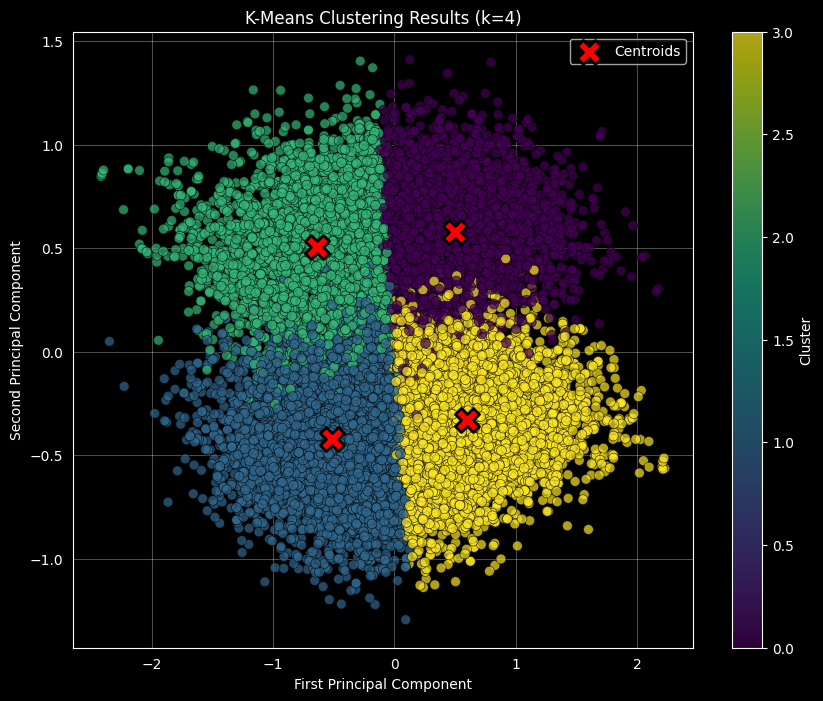

In [32]:
from sklearn.decomposition import PCA

# Fit KMeans
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
labels = kmeans.fit_predict(weighted_df)

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2, random_state=42)
data_2d = pca.fit_transform(weighted_df)

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels,
                      cmap='viridis', s=50, alpha=0.7, edgecolors='black', linewidth=0.5)

# Transform centroids to 2D space
centroids_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1],
            c='red', marker='X', s=300, edgecolors='black', linewidth=2,
            label='Centroids')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-Means Clustering Results (k=4)')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


WCSS

In [33]:
wcss = 0
for i in range(len(kmeans.cluster_centers_)):
    cluster_points = weighted_df[labels == i]
    if len(cluster_points) > 0:
        distances_squared = np.sum((cluster_points - kmeans.cluster_centers_[i]) ** 2, axis=1)
        wcss += np.sum(distances_squared)

difference = abs(wcss - kmeans.inertia_)
percentage_difference = (difference / kmeans.inertia_) * 100

print(f"WCSS Score for K-Means with k={best_k} : {wcss:.2f}")
print(f"Inertie : {kmeans.inertia_:.2f}")
print(f"Différence: {difference:.6f}")
print(f"Percentage difference : {percentage_difference:.4f}%")

if percentage_difference < 1:
    print("Very Good: The clusters are well compact and the model is not overfitting.")
elif percentage_difference >= 1 and percentage_difference < 3 :
    print("Good: The clusters are well compact and the model is not overfitting.")
else : 
    print("Bad: The clusters are not well compact and the model is overfitting.")
    


WCSS Score for K-Means with k=4 : 30989.83
Inertie : 30989.83
Différence: 0.000000
Percentage difference : 0.0000%
Very Good: The clusters are well compact and the model is not overfitting.


Silhouette score

In [34]:
from sklearn.metrics import silhouette_score, silhouette_samples

silhouette_avg = silhouette_score(weighted_df, labels)

sample_silhouette_values = silhouette_samples(weighted_df, labels)

print(f"Silhouette Score : {silhouette_avg:.4f}")

# Analyse détaillée par cluster
for i in range(best_k):
    cluster_silhouette_values = sample_silhouette_values[labels == i]
    cluster_mean = np.mean(cluster_silhouette_values)
    cluster_size = len(cluster_silhouette_values)

    print(f"Cluster {i}: Average Score = {cluster_mean:.4f}, Size = {cluster_size}")

negative_points = np.sum(sample_silhouette_values < 0)
total_points = len(sample_silhouette_values)
percentage_negative = (negative_points / total_points) * 100

if silhouette_avg >= 0.7:
    print("Very Good")
elif silhouette_avg >= 0.5:
    print("Good")
elif silhouette_avg >= 0.25:
    print("Séparation is ok")
else:
    print("Bad Séparation")

Silhouette Score : 0.0909
Cluster 0: Average Score = 0.0913, Size = 3287
Cluster 1: Average Score = 0.0874, Size = 4696
Cluster 2: Average Score = 0.0841, Size = 3271
Cluster 3: Average Score = 0.0988, Size = 4717
Bad Séparation
